# Analyze DL/ML results

## Setup

In [ ]:
from fastbook import *
from scipy.optimize import minimize
from katlas.imports import *
import seaborn as sns

## Load data

In [ ]:
# read training data
df = pd.read_parquet('train_data/combine_t5_kd.parquet').reset_index()
# column name of feature and target
feat_col = df.columns[df.columns.str.startswith('T5_')]
target_col = df.columns[~df.columns.isin(feat_col)][1:]

y = df[target_col]

In [ ]:
oof_results = pd.read_pickle('raw/oof.pkl')

In [ ]:
source = pd.read_excel('train_data/combine_info_PSPA.xlsx').iloc[:,:2]

info = Data.get_kinase_info().query('pseudo !="1"')

info = source.merge(info)

## Ensemble

The goal here is to use different weights for each oof to optimize the results; then choose the top models, and re-ensemble them and see their weights.

In [ ]:
def ensemble(oof_results, # dictionary of oofs
             y # target df
            ):
    
    "Ensemble a dictionary of OOFs"
    
    oofs = np.zeros((len(oof_results), y.shape[0], y.shape[1]))
    y_true = y.values
    
    for i in range(oofs.shape[0]):
        oofs[i] = list(oof_results.values())[i]
        
    # The sum of weights is 1 (because we normalize it)
    cons = ({'type':'eq','fun':lambda w: 1-sum(w)})

    # Each weight is bounded between 0 and 1
    num_models = len(oofs)
    bounds = [(0, 1)] * num_models

    # Initial guess - divide 1 equally among all models
    initial_weights = [1./num_models] * num_models
    
    # Objective function to minimize (Mean Squared Error)
    def objective(weights): 
        ''' Minimize negative Mean Squared Error to find the best weights '''
        final_prediction = sum(w * oof for w, oof in zip(weights, oofs))
        return np.mean((final_prediction - y_true) ** 2)

    # Use 'trust-constr' or 'SLSQP' method to ensure constraints are followed
    result = minimize(objective, initial_weights, method='SLSQP', bounds=bounds, constraints=cons)
    # result = minimize(objective, initial_weights, method='trust-constr', bounds=bounds, constraints=cons, options={'maxiter': 5000})

    # Check whether it is converged
    print(f'result: {result.success}')
    print(result.message)

    # Extract the optimized weights
    best_weights = result.x
    # print(best_weights)
    
    weights = {}

    i = 0
    for k,v in oof_results.items():
        weights[k] = best_weights[i]
        i+=1
        
    weights_df = pd.DataFrame(weights.items(),columns=['model','weights'])
    
    display(weights_df.sort_values('weights',ascending=False))
    
    final_prediction = sum(w * oof for w, oof in zip(best_weights, oofs))
    oof_w = pd.DataFrame(final_prediction,columns=target_col)
    
    return weights_df, oof_w

In [ ]:
# get ensemble weights for each oof
weights,oof_ensemble = ensemble(oof_results,y)

result: True
Optimization terminated successfully


,model,weights
5,cnn_t5_kd,2.229052e-01
7,cnn_esm_kd,2.044781e-01
4,cnn_t5,1.372858e-01
19,Ridge_esm_kd,7.176390e-02
29,KNN_t5_kd,7.153355e-02
11,LinearRegression_esm_kd,5.621854e-02
10,LinearRegression_esm,5.518402e-02
9,LinearRegression_t5_kd,4.254569e-02
6,cnn_esm,4.045877e-02
28,KNN_t5,2.837086e-02


In [ ]:
_ = score_each(y,oof_ensemble)

overall MSE: 0.2979
Average Pearson: 0.8240 


Then we choose the top three models and ensemble them.

In [ ]:
top = ['cnn_t5_kd','cnn_esm_kd','cnn_t5']

In [ ]:
oofs2 = {key: oof_results[key] for key in top}

In [ ]:
weights2,oof_ensemble2 = ensemble(oofs2,y)

result: True
Optimization terminated successfully


,model,weights
1,cnn_esm_kd,0.370932
0,cnn_t5_kd,0.350575
2,cnn_t5,0.278493


In [ ]:
_,_,corr = score_each(y,oof_ensemble2)

overall MSE: 0.3081
Average Pearson: 0.8174 


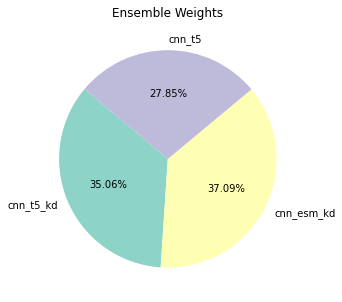

In [ ]:
# Pie Chart
labels = weights2.model
sizes =  weights2.weights

plt.figure(figsize=(5, 5))
plt.pie(sizes, labels=labels, autopct='%1.2f%%', startangle=140, colors=sns.color_palette("Set3", len(weights2)))
plt.title("Ensemble Weights")
plt.show()

As it looks to be an average of the three models, we'll take the average of them

In [ ]:
oof_ensemble = (oof_results['cnn_t5_kd'] + oof_results['cnn_esm_kd'] + oof_results['cnn_t5']) / 3

In [ ]:
oof_ensemble

,-5P,-5G,-5A,-5C,-5S,-5T,-5V,-5I,-5L,-5M,-5F,-5Y,-5W,-5H,-5K,-5R,-5Q,-5N,-5D,-5E,-5s,-5t,-5y,-4P,-4G,-4A,-4C,-4S,-4T,-4V,-4I,-4L,-4M,-4F,-4Y,-4W,-4H,-4K,-4R,-4Q,-4N,-4D,-4E,-4s,-4t,-4y,-3P,-3G,-3A,-3C,-3S,-3T,-3V,-3I,-3L,-3M,-3F,-3Y,-3W,-3H,-3K,-3R,-3Q,-3N,-3D,-3E,-3s,-3t,-3y,-2P,-2G,-2A,-2C,-2S,-2T,-2V,-2I,-2L,-2M,-2F,-2Y,-2W,-2H,-2K,-2R,-2Q,-2N,-2D,-2E,-2s,-2t,-2y,-1P,-1G,-1A,-1C,-1S,-1T,-1V,-1I,-1L,-1M,-1F,-1Y,-1W,-1H,-1K,-1R,-1Q,-1N,-1D,-1E,-1s,-1t,-1y,1P,1G,1A,1C,1S,1T,1V,1I,1L,1M,1F,1Y,1W,1H,1K,1R,1Q,1N,1D,1E,1s,1t,1y,2P,2G,2A,2C,2S,2T,2V,2I,2L,2M,2F,2Y,2W,2H,2K,2R,2Q,2N,2D,2E,2s,2t,2y,3P,3G,3A,3C,3S,3T,3V,3I,3L,3M,3F,3Y,3W,3H,3K,3R,3Q,3N,3D,3E,3s,3t,3y,4P,4G,4A,4C,4S,4T,4V,4I,4L,4M,4F,4Y,4W,4H,4K,4R,4Q,4N,4D,4E,4s,4t,4y,0s,0t,0y
0,0.188878,0.634647,0.887343,-0.927092,-0.392501,-0.586569,0.142022,0.007973,0.562061,-0.993858,-0.566768,-1.220567,-1.158315,-0.642133,1.120802,0.364175,0.375434,0.055257,1.663378,2.376884,-0.301946,-0.794536,-0.552649,0.190727,1.270748,0.513715,-0.854113,-0.487572,-0.638809,0.230982,-0.242128,1.036821,-0.792146,-0.403138,-1.319813,-1.409867,-0.841248,0.476729,0.362317,-0.164695,-0.232484,1.704270,2.104024,0.291016,-0.687562,-0.548687,0.069685,0.753290,1.037177,-1.145434,-0.621697,-0.929131,0.163861,-0.488886,0.603018,-0.976631,-0.657797,-1.337881,-1.360138,-0.648267,0.672734,0.166015,0.424121,0.005110,1.784140,3.080080,0.135212,-0.625342,-0.208076,0.522695,1.255310,0.811666,-1.000513,-0.704257,-0.894888,0.036102,-0.181274,0.143785,-1.174770,-0.859642,-1.324347,-1.155678,-0.889019,0.587813,-0.260471,0.352046,0.267965,2.108112,2.557907,0.359679,-0.419893,-0.191064,-0.031897,-0.041261,0.768281,-1.046224,-1.056009,-0.841082,1.678762,1.474963,2.380413,-1.209911,-0.328476,-1.353052,-1.178340,-0.810562,-0.073252,-0.627969,-0.244801,-0.143653,1.185254,1.820870,-0.503965,0.033932,0.055079,-0.990394,2.050974,1.202434,-0.896472,-0.751740,-1.074353,0.673735,0.215778,0.388112,-0.904532,-0.696476,-1.325945,-1.133978,-0.718839,-0.004357,-0.723982,0.306474,-0.201503,1.981238,3.301958,0.194510,-0.673171,-0.147423,-0.012991,0.666403,1.149449,-0.809711,-0.726497,-0.936235,0.676131,-0.102694,0.933665,-0.895986,-0.314606,-1.249670,-1.060242,-0.775663,0.120224,-0.079433,-0.139687,0.144503,1.457012,2.152325,0.207267,-0.323534,-0.220516,0.579143,0.581741,0.764128,-0.780944,-0.667929,-0.927524,0.894377,0.651753,2.628730,-0.783616,-0.169506,-1.289550,-1.116577,-0.653992,0.193128,0.715483,-0.328777,-0.497816,0.547089,0.568319,-0.167851,-0.542341,-0.194183,0.416947,0.874074,1.057034,-0.942906,-0.373124,-0.787586,0.601266,-0.254105,0.793548,-0.834147,-0.294836,-1.225388,-1.186767,-0.653884,0.888362,0.690264,-0.043264,-0.115584,1.033319,1.457796,-0.159984,-0.520591,-0.457668,-0.704891,-0.679028,1.414340
1,-0.025378,0.714929,0.920944,-1.022550,-0.377764,-0.636222,0.134602,-0.041053,0.666049,-0.975972,-0.436032,-1.089625,-1.148152,-0.615748,1.547186,0.616245,0.263874,0.219127,1.361456,1.681483,-0.458307,-0.781143,-0.551071,0.131412,1.280712,0.343339,-0.892329,-0.411230,-0.595306,0.272755,-0.149464,1.104624,-0.778450,-0.379281,-1.217710,-1.201595,-0.732177,0.788771,0.675667,-0.106178,-0.085377,1.359592,1.520061,0.125365,-0.668326,-0.569933,0.217928,0.803164,1.125930,-1.078663,-0.694710,-0.892364,0.308811,-0.217046,0.690249,-0.967827,-0.508961,-1.235178,-1.157629,-0.601595,0.733407,0.290156,0.361249,-0.081060,1.511702,2.072425,0.152596,-0.614647,-0.341213,0.232904,0.967064,0.870205,-0.957279,-0.700066,-1.014585,0.176937,-0.020815,0.229948,-1.000263,-0.768759,-1.291999,-1.003731,-0.901384,1.032405,0.113560,0.275431,-0.084332,1.372409,2.307034,0.361895,-0.367394,-0.101802,-0.505137,-0.005732,0.529710,-1.089594,-1.030629,-0.930996,0.675152,0.595349,1.792188,-1.231175,-0.360018,-1.313301,-1.248776,-0.891328,-0.034980,-0.276024,-0.269184,0.695430,3.171903,2.060493,-0.313544,-0.091605,0.062153,-0.884825,0.876114,1.224441,-0.919931,-0.917134,-1.074066,1.190683,0.769583,0.686133,-0.905399,-0.505974,-1.319224,-1.148758,-0.704071,-0.205

### OOF Pearson score by family

In [ ]:
_,_,corr = score_each(oof_ensemble,y)

overall MSE: 0.3086
Average Pearson: 0.8170 


In [ ]:
corr = pd.concat([corr, info],axis=1)

In [ ]:
corr_family = corr.groupby('family').agg({'Pearson':'mean','kinase':'count'})

In [ ]:
corr_family.sort_values('Pearson',ascending=False)

,Pearson,kinase
family,,
Sev,0.981550,1
Met,0.979476,2
InsR,0.978676,3
Eph,0.976189,12
Akt,0.974935,3
...,...,...
KIS,0.102436,1
Bud32,0.096503,1
FAM20C,0.086976,1


In [ ]:
corr_family.to_csv('raw/oof_corr_family.csv')

In [ ]:
corr_subfamily = corr.groupby('subfamily').agg({'Pearson':'mean','kinase':'count'})

In [ ]:
corr_subfamily.sort_values('kinase',ascending=False)

,Pearson,kinase
subfamily,,
Eph,0.976189,12
Src,0.967152,11
NEK,0.778235,10
STE11,0.749903,7
CK1,0.948548,7
...,...,...
SNRK,0.700188,1
NKF2,0.301151,1
CDK9,0.943745,1


In [ ]:
corr_subfamily.to_csv('raw/oof_corr_subfamily.csv')

## Plot

In [ ]:
sns.set(rc={"figure.dpi":300, 'savefig.dpi':300})
sns.set_context('notebook')
sns.set_style("ticks")

In [ ]:
corr

,Pearson,kinase,source,ID_coral,uniprot,ID_HGNC,group,family,subfamily_coral,subfamily,in_ST_paper,in_Tyr_paper,in_cddm,pseudo,pspa_category_small,pspa_category_big,cddm_big,cddm_small,length,human_uniprot_sequence,kinasecom_domain,nucleus,cytosol,cytoskeleton,plasma membrane,mitochondrion,Golgi apparatus,endoplasmic reticulum,vesicle,centrosome,aggresome,main_location
0,0.980211,SRC,KS,SRC,P12931,SRC,TK,Src,None,Src,0,1,1,0,SRC,SRC,1.0,2.0,536,MGSNKSKPKDASQRRRSLEPAENVHGAGGGAFPASQTPSKPASADGHRGPSAAFAPAAAEPKLFGGFNSSDTVTSPQRAGPLAGGVTTFVALYDYESRTETDLSFKKGERLQIVNNTEGDWWLAHSLSTGQTGYIPSNYVAPSDSIQAEEWYFGKITRRESERLLLNAENPRGTFLVRESETTKGAYCLSVSDFDNAKGLNVKHYKIRKLDSGGFYITSRTQFNSLQQLVAYYSKHADGLCHRLTTVCPTSKPQTQGLAKDAWEIPRESLRLEVKLGQGCFGEVWMGTWNGTTRVAIKTLKPGTMSPEAFLQEAQVMKKLRHEKLVQLYAVVSEEPIYIVTEYMSKGSLLDFLKGETGKYLRLPQLVDMAAQIASGMAYVERMNYVHRDLRAANILVGENLVCKVADFGLARLIEDNEYTARQGAKFPIKWTAPEAALYGRFTIKSDVWSFGILLTELTTKGRVPYPGMVNREVLDQVERGYRMPCPPECPESLHDLMCQCWRKEPEERPTFEYLQAFLEDYFTSTEPQYQPGENL,LRLEVKLGQGCFGEVWMGTWNGTTRVAIKTLKPGTMSPEAFLQEAQVMKKLRHEKLVQLYAVVSEEPIYIVTEYMSKGSLLDFLKGETGKYLRLPQLVDMAAQIASGMAYVERMNYVHRDLRAANILVGENLVCKVADFGLARLIEDNEYTARQGAKFPIKWTAPEAALYGRFTIKSDVWSFGILLTELTTKGRVPYPGMVNREVLDQVERGYRMPCPPECPESLHDLMCQCWRKEPEERPTFEYLQAF,NaN,2.0,NaN,6.0,NaN,2.0,NaN,NaN,NaN,NaN,plasma membrane
1,0.986307,EPHA3,KS,EphA3,P29320,EPHA3,TK,Eph,None,Eph,0,1,1,0,Ephrin receptors,Ephrin receptors,1.0,2.0,983,MDCQLSILLLLSCSVLDSFGELIPQPSNEVNLLDSKTIQGELGWISYPSHGWEEISGVDEHYTPIRTYQVCNVMDHSQNNWLRTNWVPRNSAQKIYVELKFTLRDCNSIPLVLGTCKETFNLYYMESDDDHGVKFREHQFTKIDTIAADESFTQMDLGDRILKLNTEIREVGPVNKKGFYLAFQDVGACVALVSVRVYFKKCPFTVKNLAMFPDTVPMDSQSLVEVRGSCVNNSKEEDPPRMYCSTEGEWLVPIGKCSCNAGYEERGFMCQACRPGFYKALDGNMKCAKCPPHSSTQEDGSMNCRCENNYFRADKDPPSMACTRPPSSPRNVISNINETSVILDWSWPLDTGGRKDVTFNIICKKCGWNIKQCEPCSPNVRFLPRQFGLTNTTVTVTDLLAHTNYTFEIDAVNGVSELSSPPRQFAAVSITTNQAAPSPVLTIKKDRTSRNSISLSWQEPEHPNGIILDYEVKYYEKQEQETSYTILRARGTNVTISSLKPDTIYVFQIRARTAAGYGTNSRKFEFETSPDSFSISGESSQVVMIAISAAVAIILLTVVIYVLIGRFCGYKSKHGADEKRLHFGNGHLKLPGLRTY...,ISIDKVVGAGEFGEVCSGRLKLPSKKEISVAIKTLKVGYTEKQRRDFLGEASIMGQFDHPNIIRLEGVVTKSKPVMIVTEYMENGSLDSFLRKHDAQFTVIQLVGMLRGIASGMKYLSDMGYVHRDLAARNILINSNLVCKVSDFGLSRVLEDDPEAAYTTRGGKIPIRWTSPEAIAYRKFTSASDVWSYGIVLWEVMSYGERPYWEMSNQDVIKAVDEGYRLPPPMDCPAALYQLMLDCWQKDRNNRPKFEQIVSI,NaN,1.0,NaN,6.0,NaN,3.0,NaN,NaN,NaN,NaN,plasma membrane
2,0.954302,FES,KS,FES,P07332,FES,TK,Fer,None,Fer,0,1,1,0,TAM receptors,TAM receptors,1.0,2.0,822,MGFSSELCSPQGHGVLQQMQEAELRLLEGMRKWMAQRVKSDREYAGLLHHMSLQDSGGQSRAISPDSPISQSWAEITSQTEGLSRLLRQHAEDLNSGPLSKLSLLIRERQQLRKTYSEQWQQLQQELTKTHSQDIEKLKSQYRALARDSAQAKRKYQEASKDKDRDKAKDKYVRSLWKLFAHHNRYVLGVRAAQLHHQHHHQLLLPGLLRSLQDLHEEMACILKEILQEYLEISSLVQDEVVAIHREMAAAAARIQPEAEYQGFLRQYGSAPDVPPCVTFDESLLEEGEPLEPGELQLNELTVESVQHTLTSVTDELAVATEMVFRRQEMVTQLQQELRNEEENTHPRERVQLLGKRQVLQEALQGLQVALCSQAKLQAQQELLQTKLEHLGPGEPPPVLLLQDDRHSTSSSEQEREGGRTPTLEILKSHISGIFRPKFSLPPPLQLIPEVQKPLHEQLWYHGAIPRAEVAELLVHSGDFLVRESQGKQEYVLSVLWDGLPRHFIIQSLDNLYRLEGEGFPSIPLLIDHLLSTQQPLTKKSGVVLHRAVPKDKWVLNHEDLVLGEQIGRGNFGEVFSGRLRADNTLVAVKSCRETL...,LVLGEQIGRGNFGEVFSGRLRADNTLVAVKSCRETLPPDLKAKFLQEARILKQYSHPNIVRLIGVCTQKQPIYIVMELVQGGDFLTFLRTEGARLRVKTLLQMVGDAAAGMEYLESKCCIHRDLAARNCLVTEKNVLKISDFGMSREEADGVYAASGGLRQVPVKWTAPEALNYGRYSSESDVWSFGILLWETFSLGASPYPNLSNQQTREFVEKGGRLPCPELCPDAVFRLMEQCWAYEPGQRPSFSTIYQELQS,NaN,6.0,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,cytosol
3,0.973414,NTRK3,KS,TRKC,Q16288,NTRK3,TK,Trk,None,Trk,0,1,1,0,Insulin and neurotrophin receptors,Insulin and neurotrophin receptors,1.0,3.0,839,MDVSLCPAKCSFWRIFLLGSVWLDYVGSVLACPANCVCSKTEINCRRPDDGNLFPLLEGQDSGNSNGNASINITDISRNITSIHIENWRSLHTLNAVDMELYTGLQKLTIKNSGLRSIQPRAFAKNPHLRYINLSSNRLTTLSWQLFQTLSLRELQLEQNFFNCSCDIRWMQLWQEQGEAKLNSQNLYCINADGSQLPLFRMNISQCDLPEISVSHVNLTVREGDNAVITCNGSGSPLPDVDWIVTGLQSINTHQTNLNWTNVHAINLTLVNVTSEDNGFTLTCIAENVVGMSNASVALTVYYPPRVVSLEEPELRLEHCIEFVVRGNPPPTLHWLHNGQPLRESKIIHVEYYQEGEISEGCLLFNKPTHYNNGNYTLIAKNPLGTANQTINGHFLKEPFPESTDNFILFDEVSPTPPITVTHKPEEDTFGVSIAVGLAAFACVLLVVLFVMINKYGRRSKFGMKGPVAVISGEEDSASPLHHINHGITTPSSLDAGPDTVVIGMTRIPVIENPQYFRQGHNCHKPDTYVQHIKRRDIV

In [ ]:
group = corr.group.unique()
group

array(['TK', 'TKL', 'Other', 'AGC', 'STE', 'CAMK', 'Atypical', 'CMGC', 'CK1'], dtype=object)

### Individual kinase group

In [ ]:
corrs = [corr.query(f'group == "{i}"') for i in group]

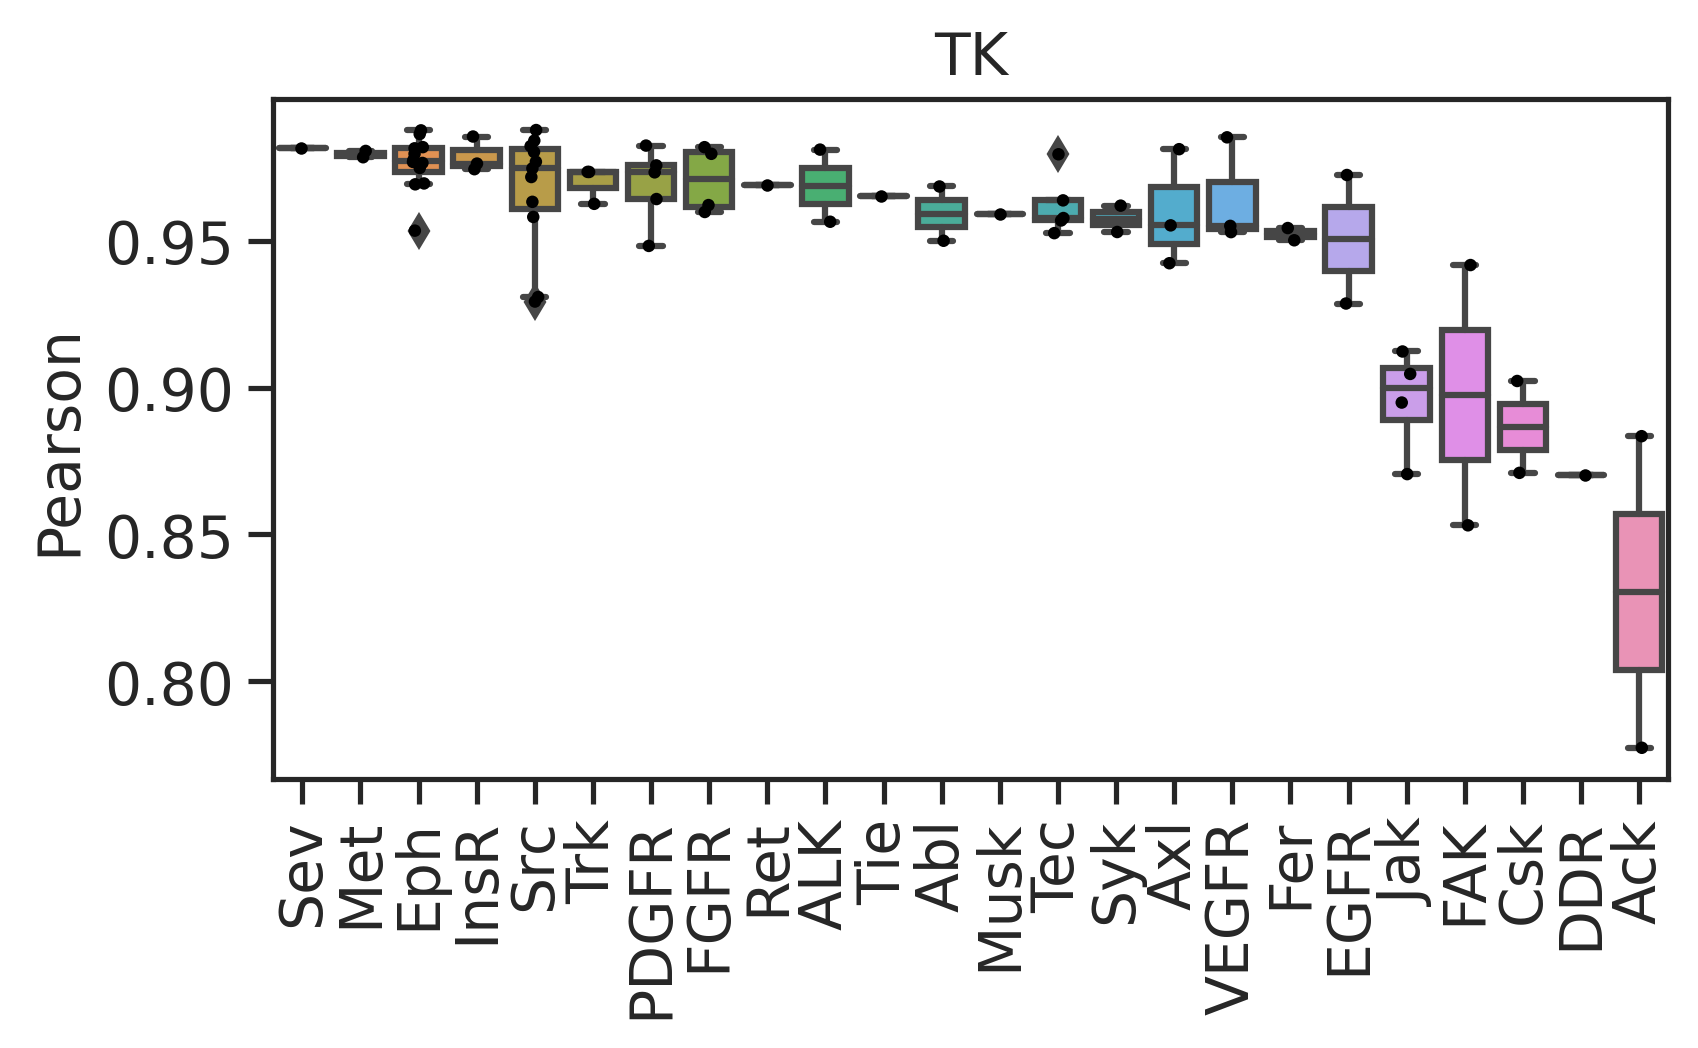

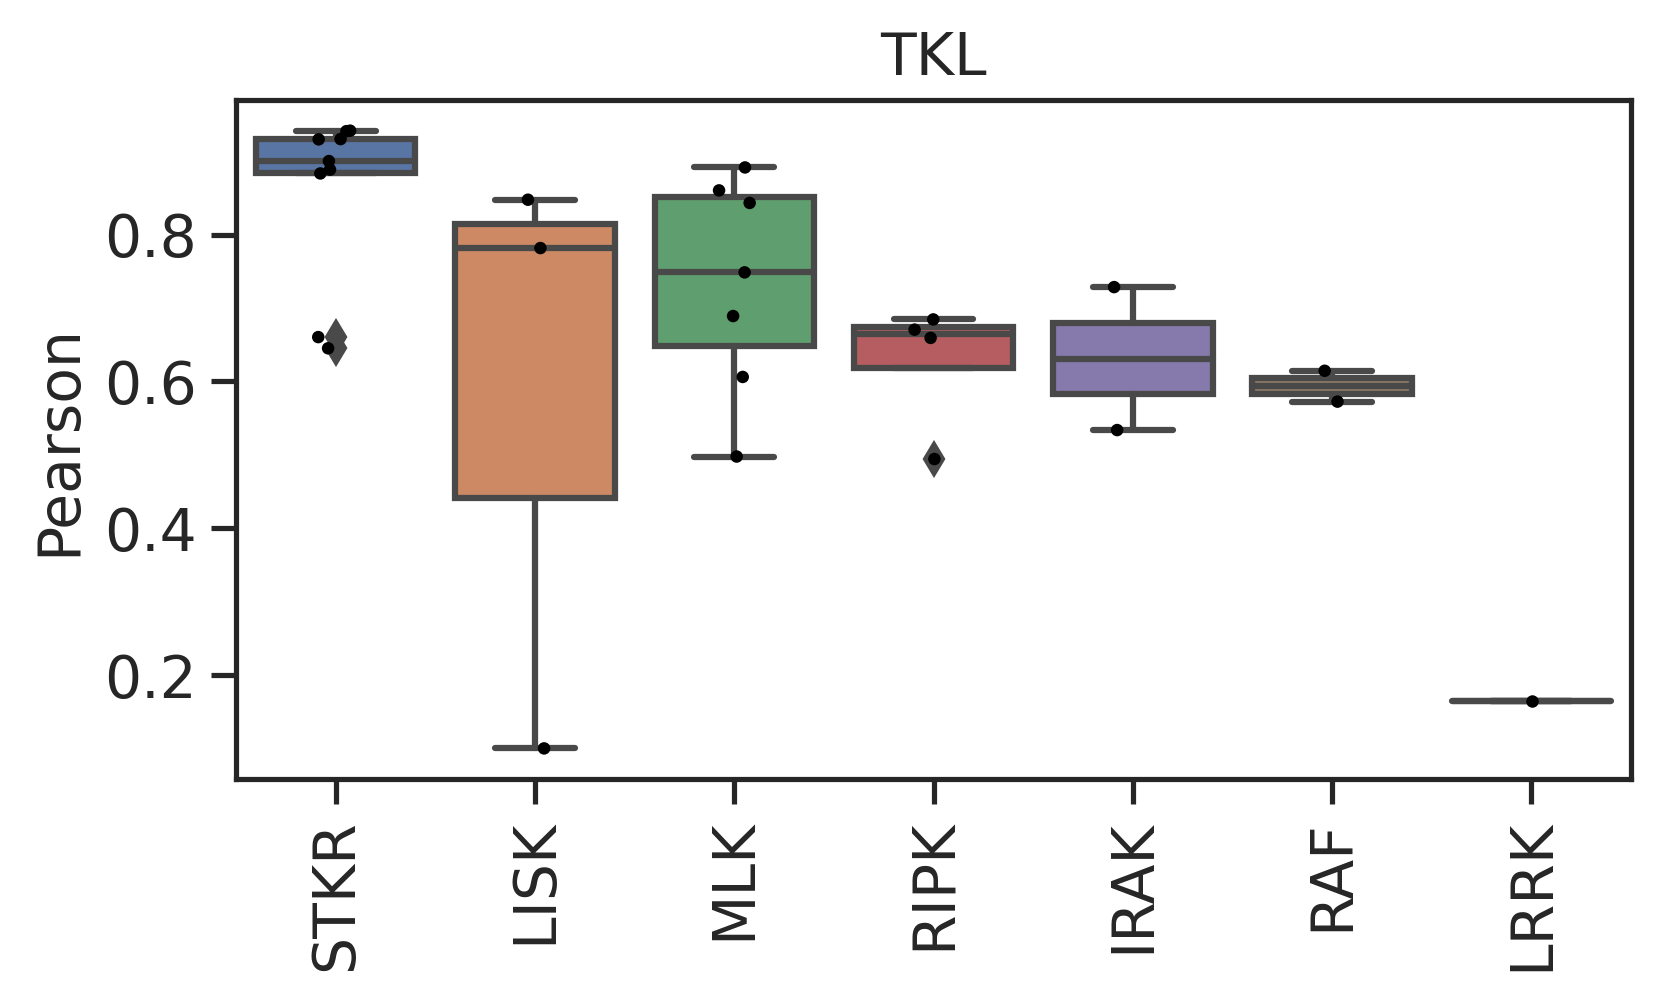

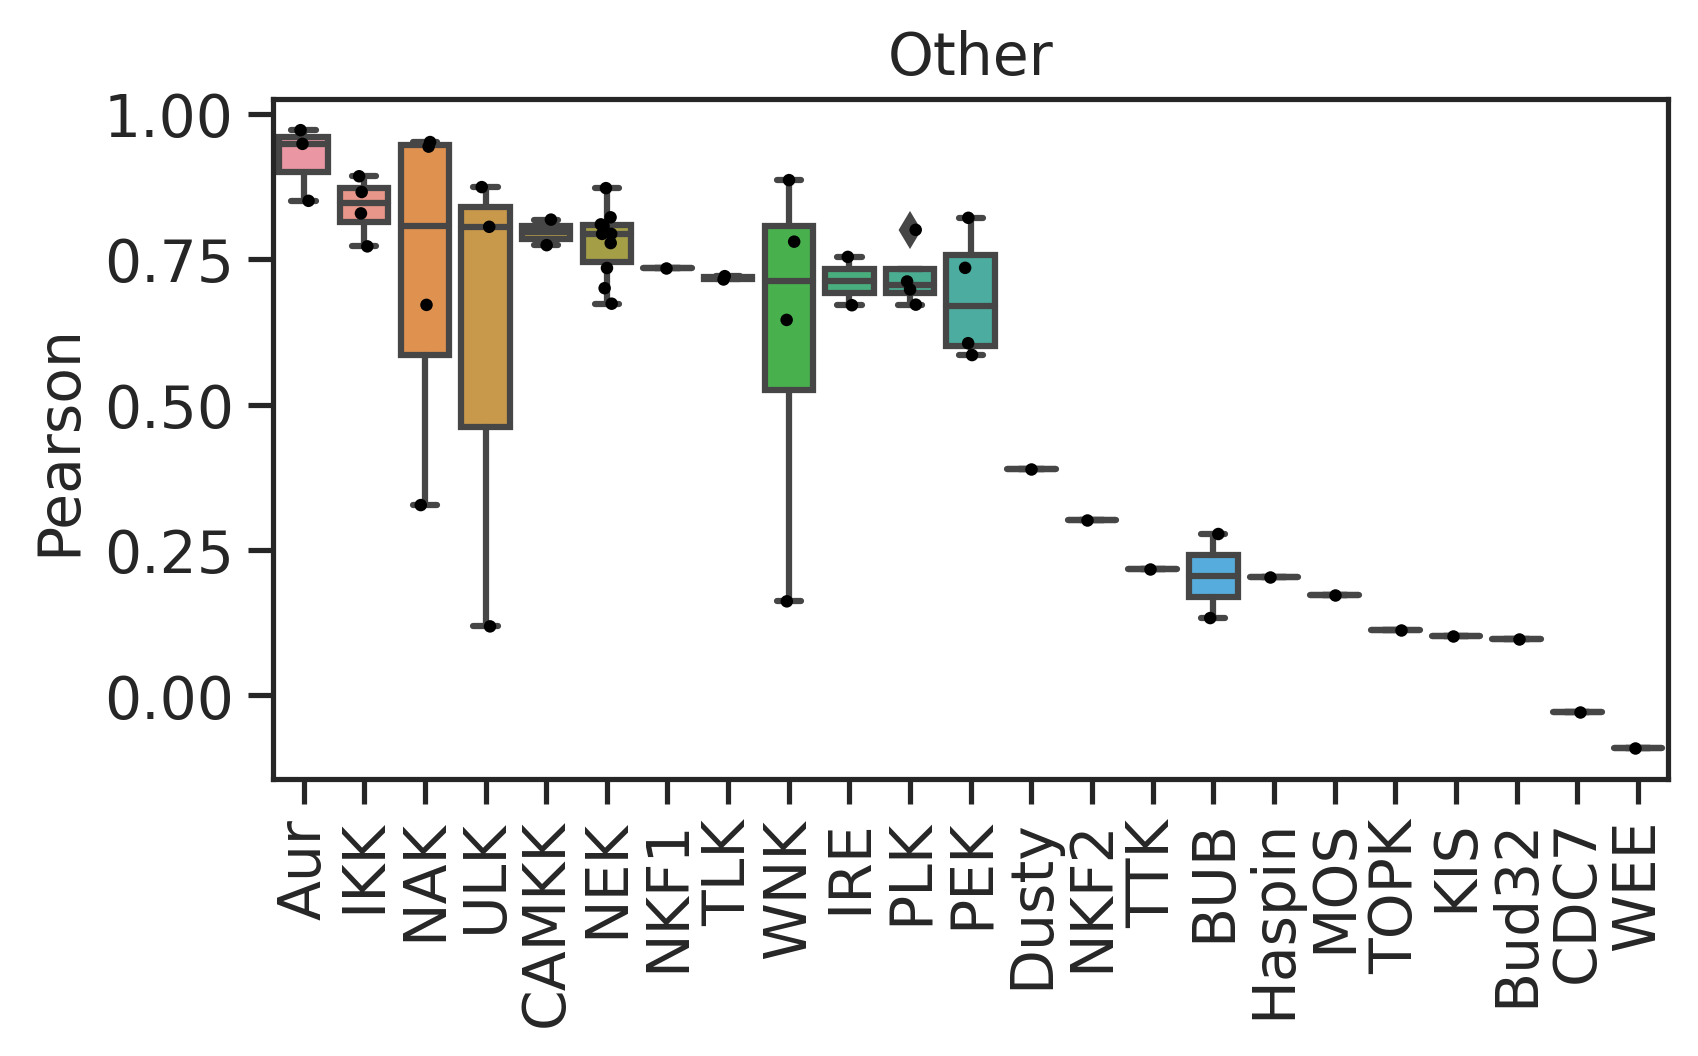

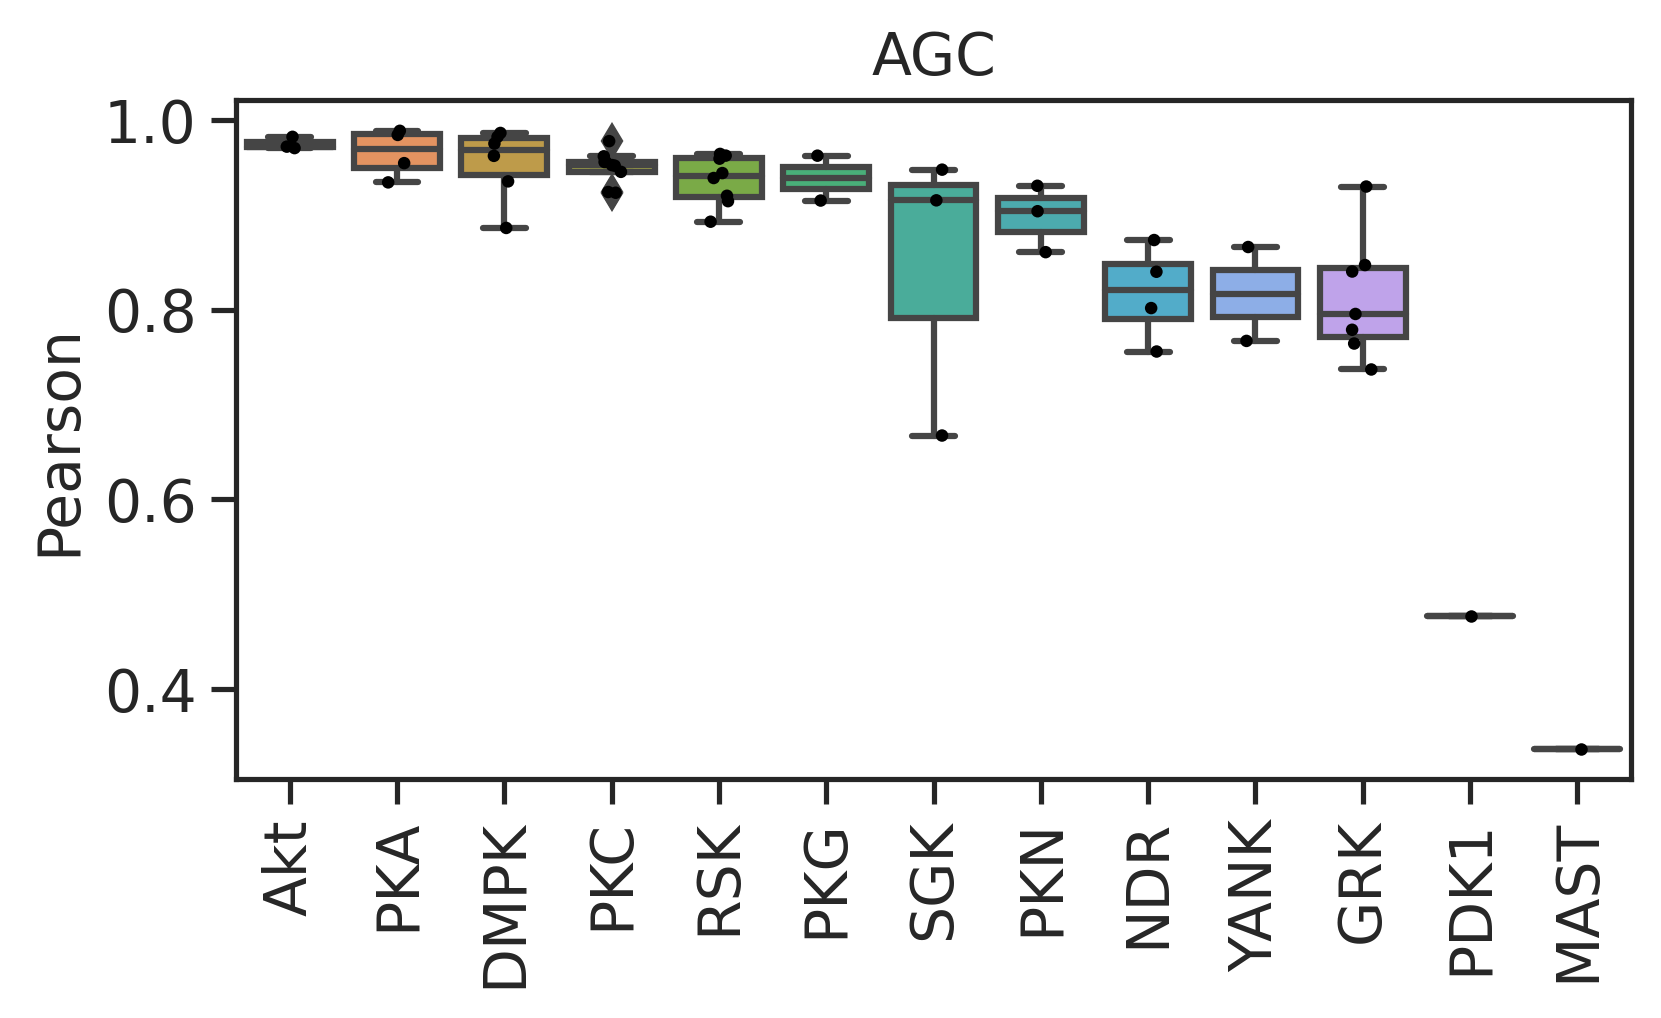

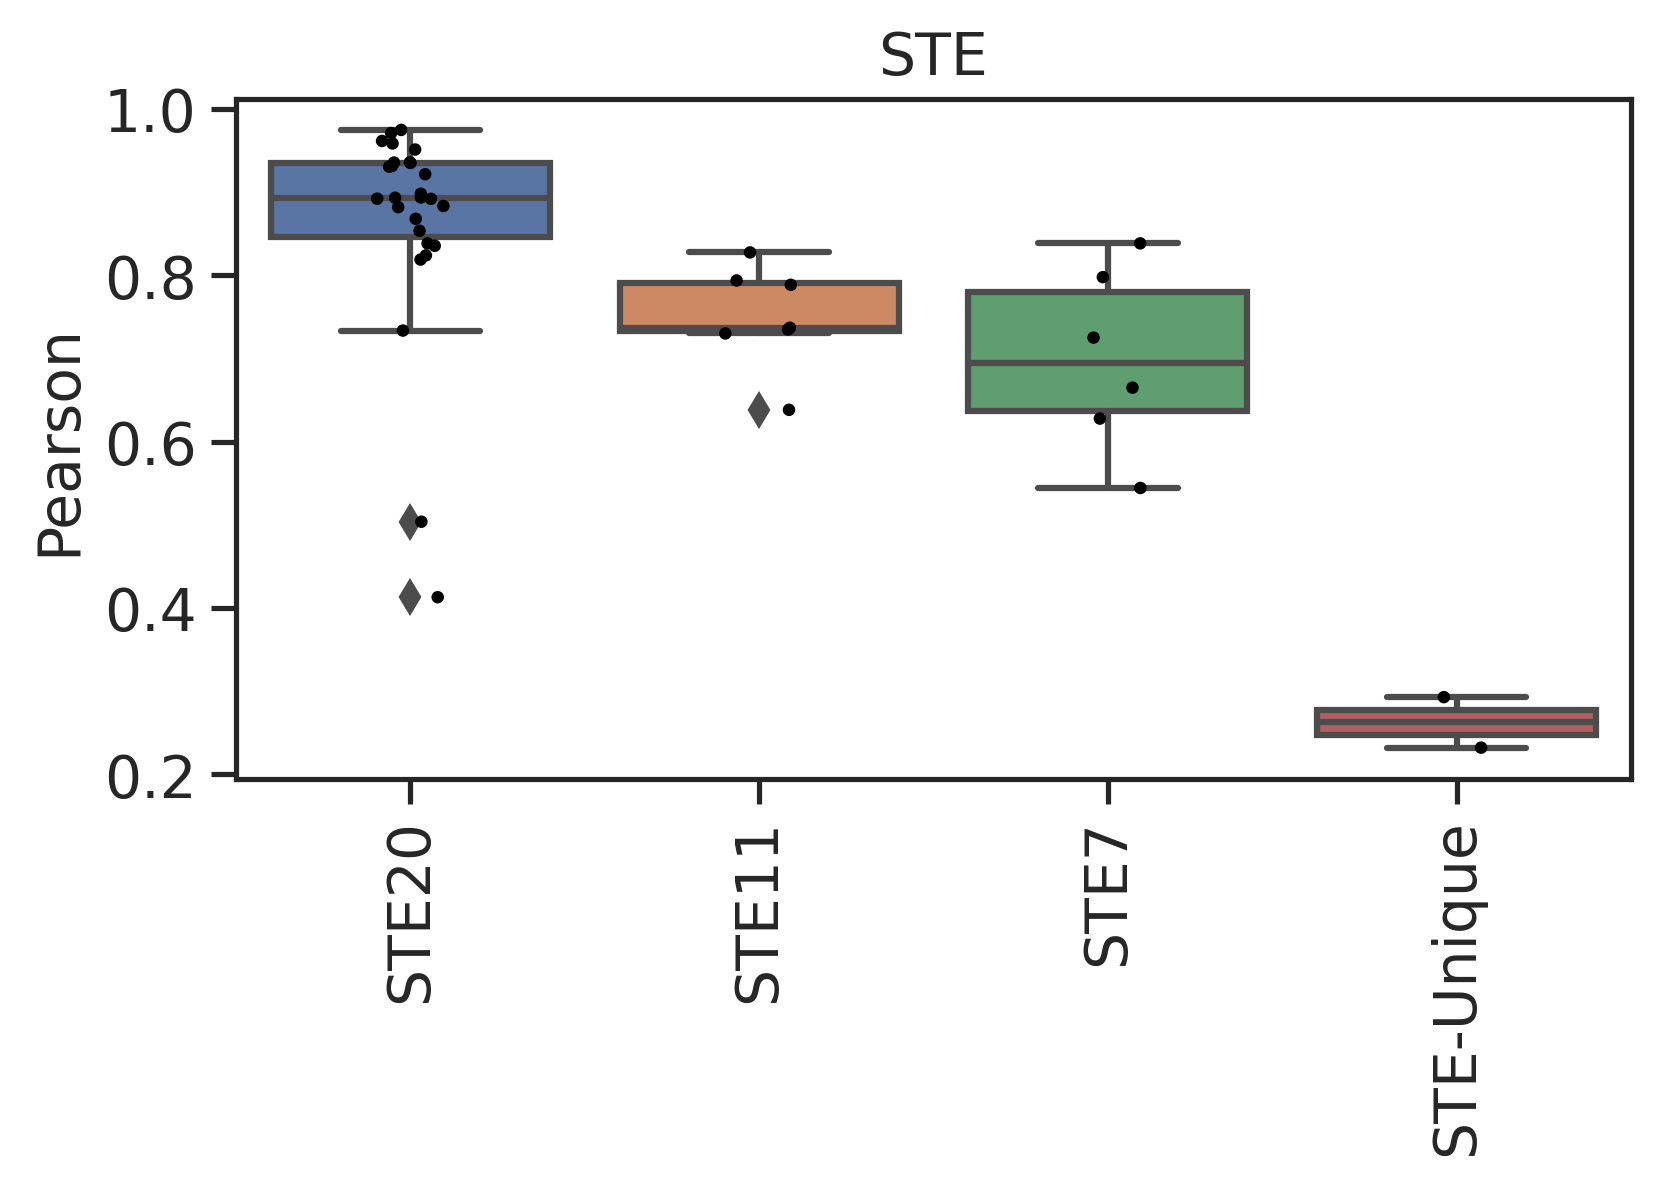

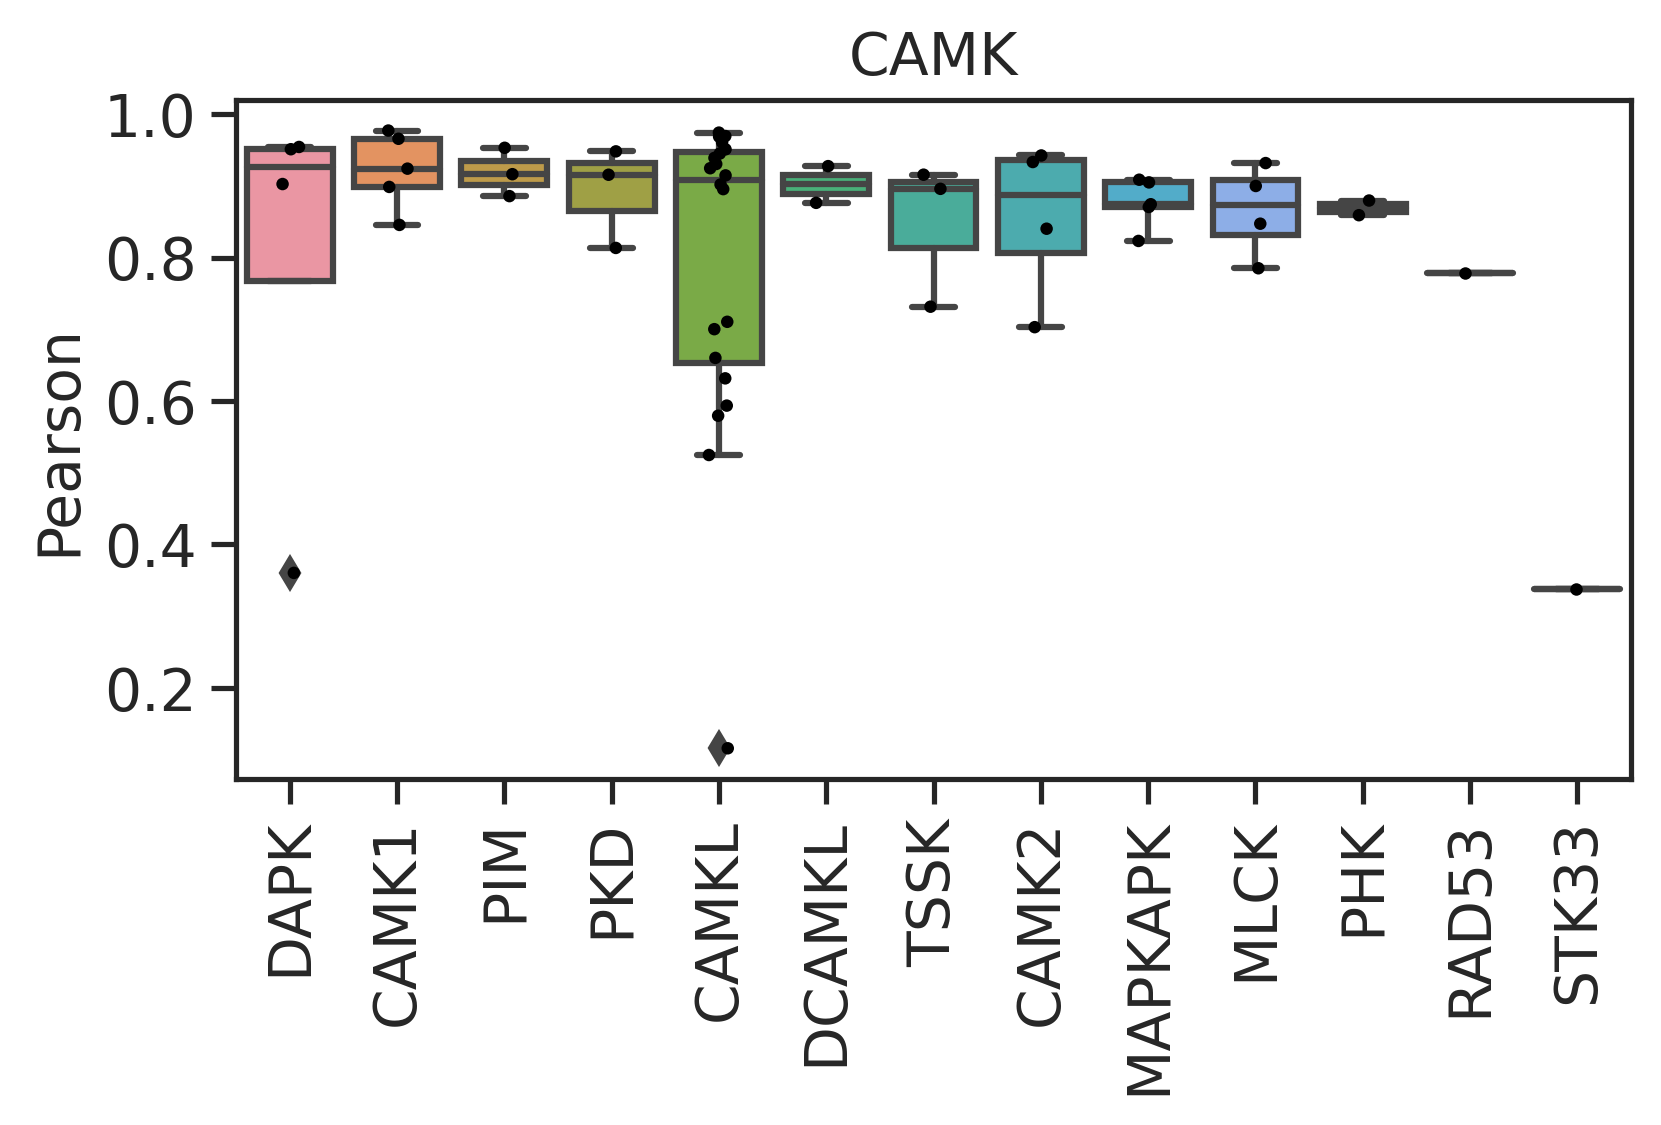

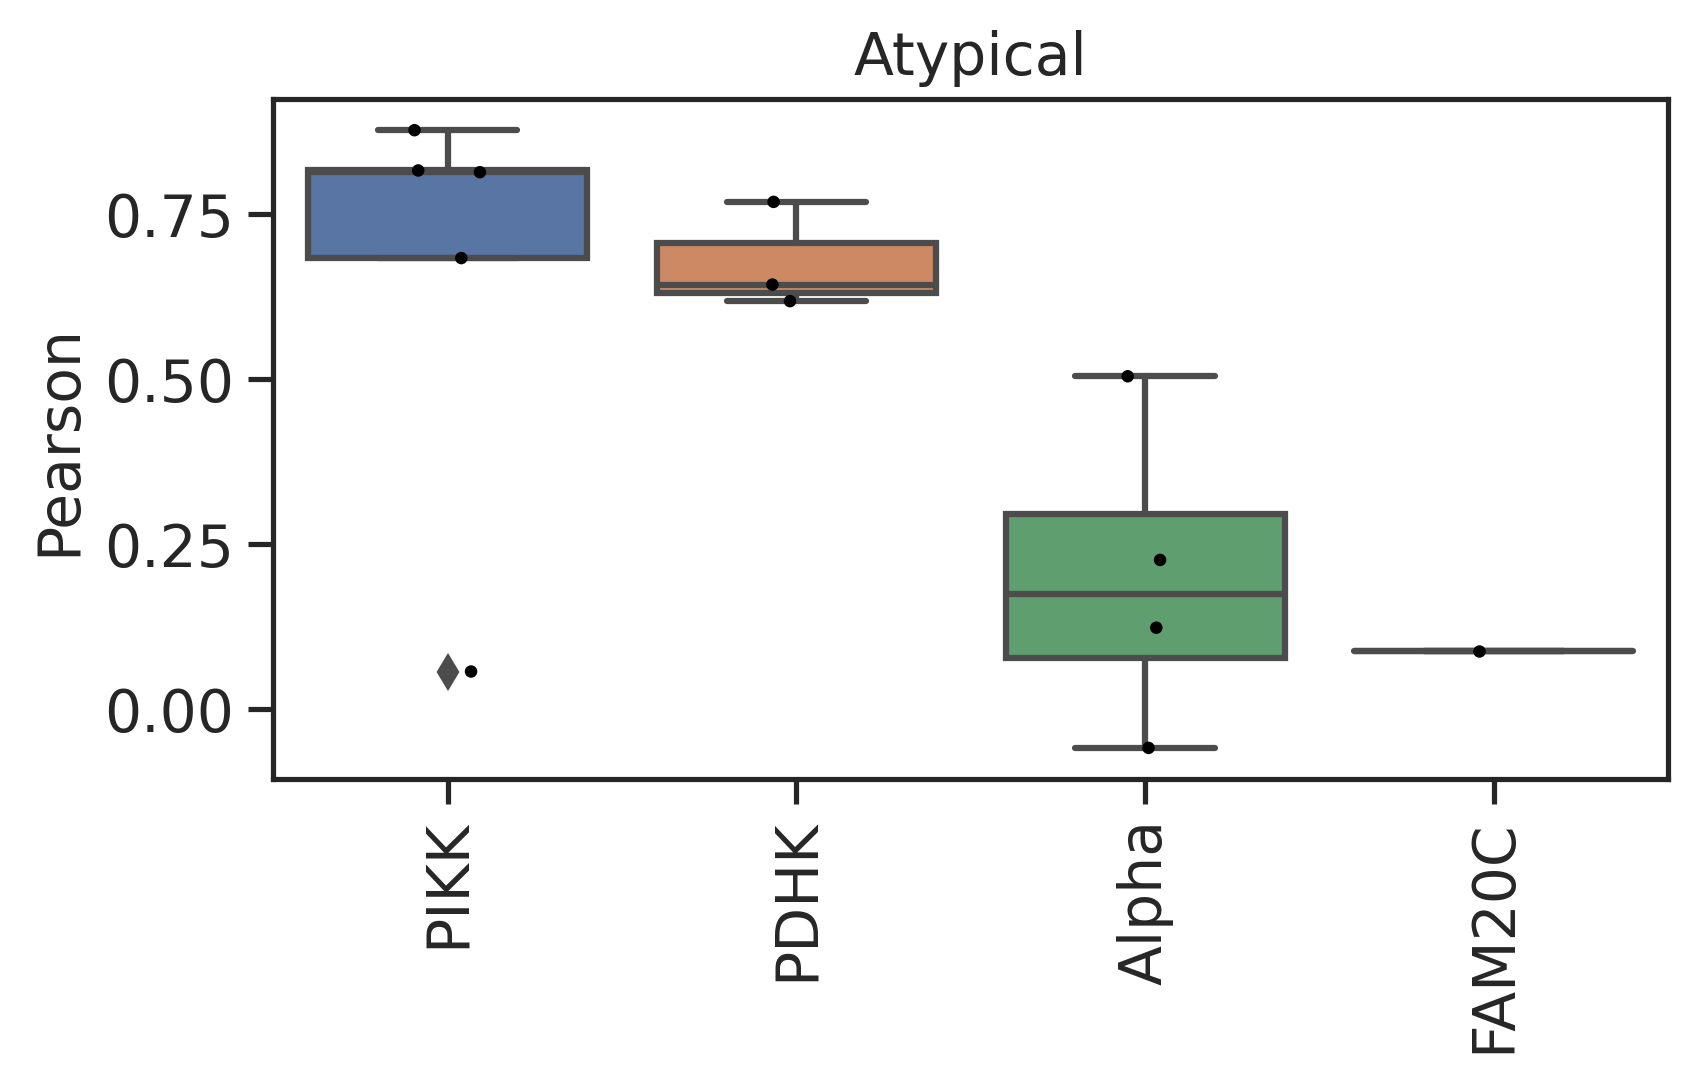

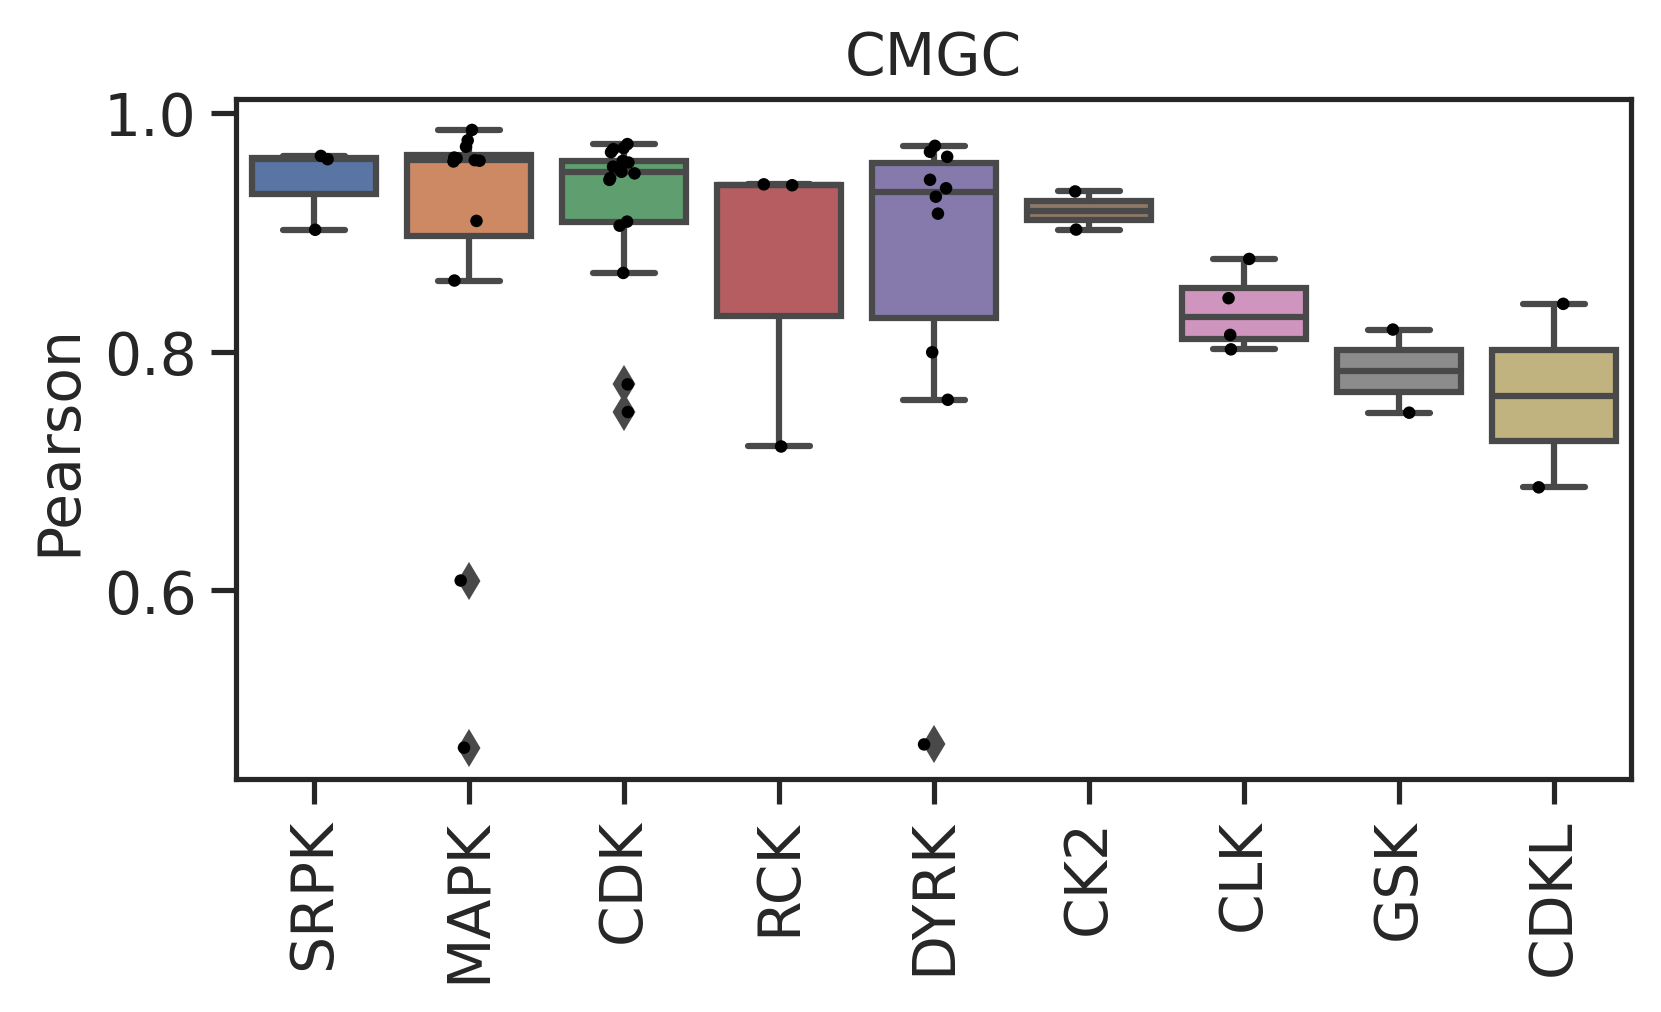

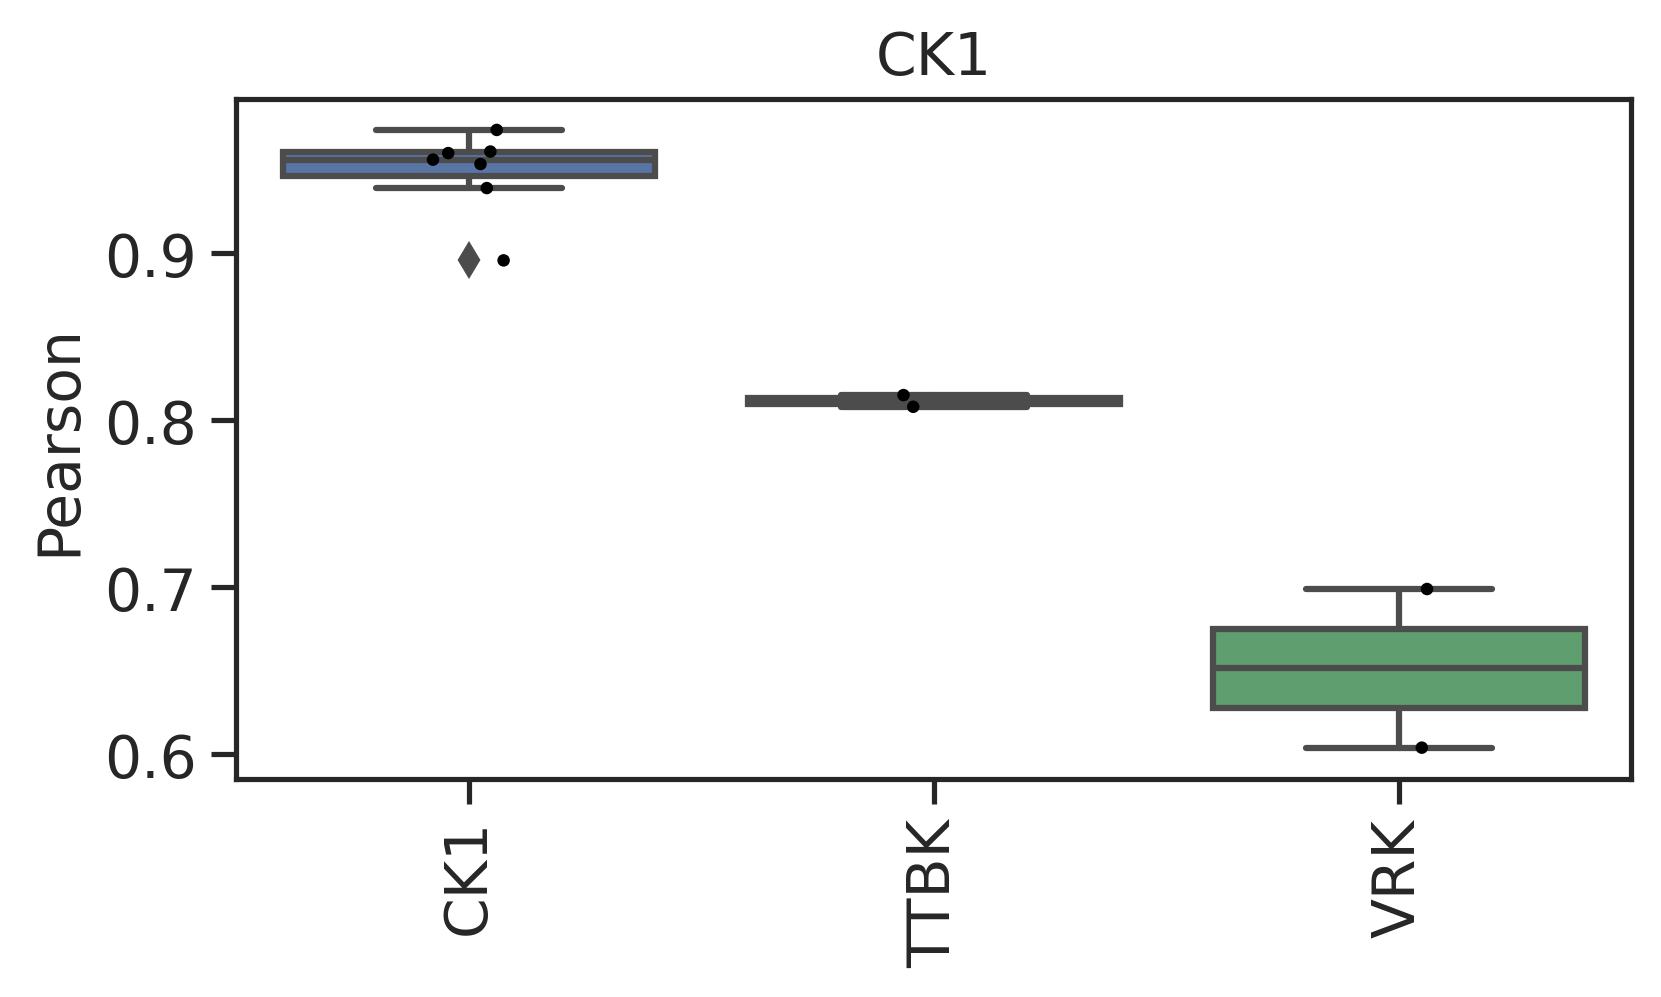

In [ ]:
for i in range(len(corrs)):
    plot_box(corrs[i],'Pearson','family',group[i])

### In general

In [ ]:
group_color = load_pickle("raw/kinase_color.pkl")

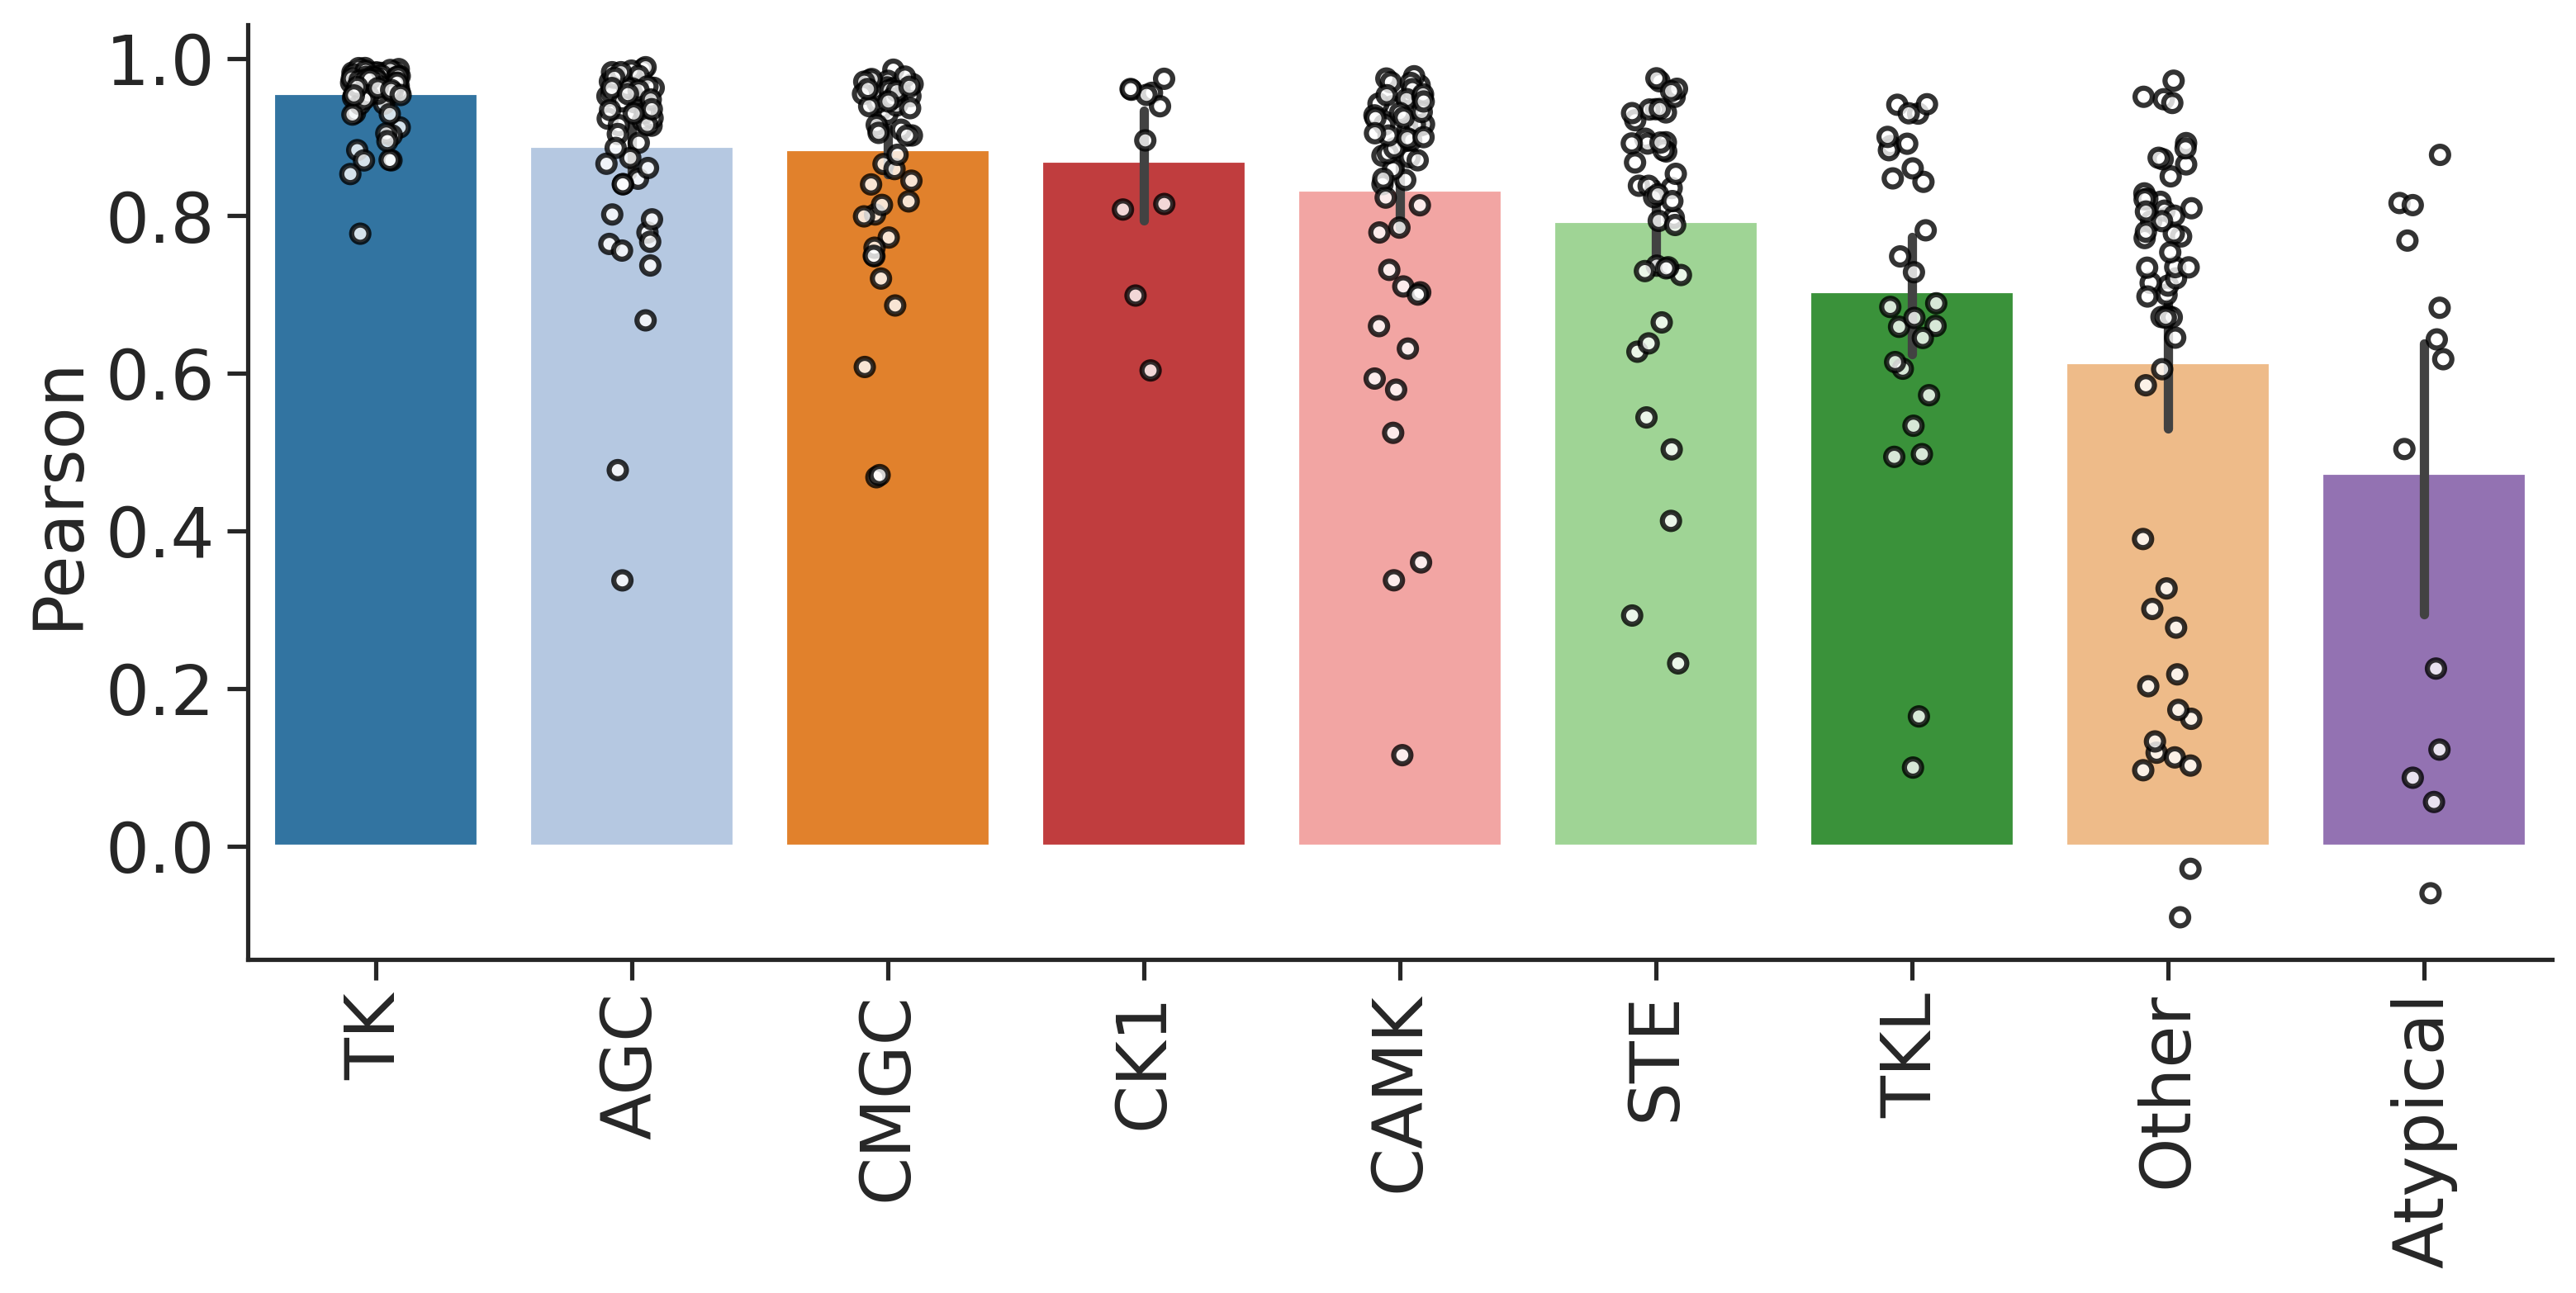

In [ ]:
plot_bar(corr,'Pearson','group',palette=group_color,fontsize=20)
# plt.title('a')

## Families with more counts

In [ ]:
family_score = corr.groupby('family').agg(family_mean=('Pearson','mean'),cnt=('Pearson','size'))

In [ ]:
family_score.sort_values('cnt',ascending=False)[:15]

,family_mean,cnt
family,,
STE20,0.863932,27
CAMKL,0.789590,20
CDK,0.923265,17
MAPK,0.881876,12
Eph,0.976189,12
Src,0.967152,11
DYRK,0.865820,10
NEK,0.778235,10
PKC,0.949881,9
